In [17]:
# Author： Zephyr Hou
# Time: 2021-08-16
# copy from https://blog.csdn.net/NBDwo/article/details/119743450
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = "mps"
device

'mps'

In [19]:
# Parameter Setting
num_epochs = 100
batch_size = 128
learning_rate = 1e-3


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Mnist digits dataset
train_data = datasets.MNIST(root='drive/My Drive/mnist/MNIST_data/', train=True, transform=img_transform, download=True)
dataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [20]:
class autoEncoder(nn.Module):
    def __init__(self):
        super(autoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
model = autoEncoder().to(device)  # autoEncoder model
loss_func = nn.MSELoss()        # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [22]:
#這邊用來呈現各15張圖，放在一起比較結果
def showImagesToCompare(images1, images2):
    figure = plt.figure(figsize=(12, 4))
    rows, cols = 3, 5
    for i in range(1, rows * cols + 1):
        oriimg = images1[i-1].squeeze(0)
        figure.add_subplot(rows, cols*2, i*2-1)
        plt.axis('off')
        plt.imshow(oriimg, cmap='gray')
        aeimg = images2[i-1].squeeze(0)
        figure.add_subplot(rows, cols*2, i*2)
        plt.axis('off')
        plt.imshow(aeimg, cmap='gray')
    plt.show()

epoch [0/100], loss:0.2035


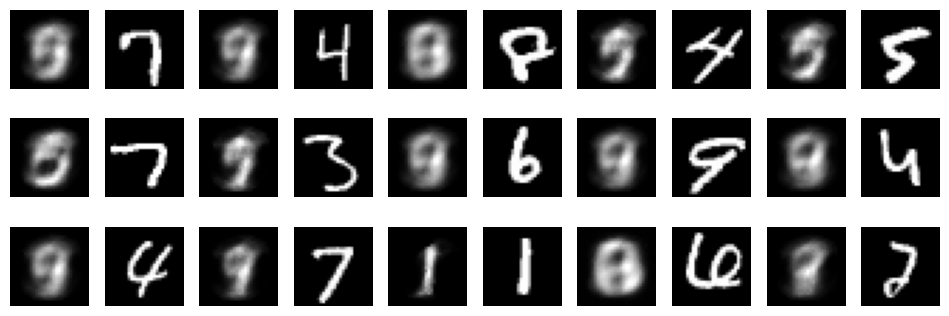

epoch [10/100], loss:0.1463


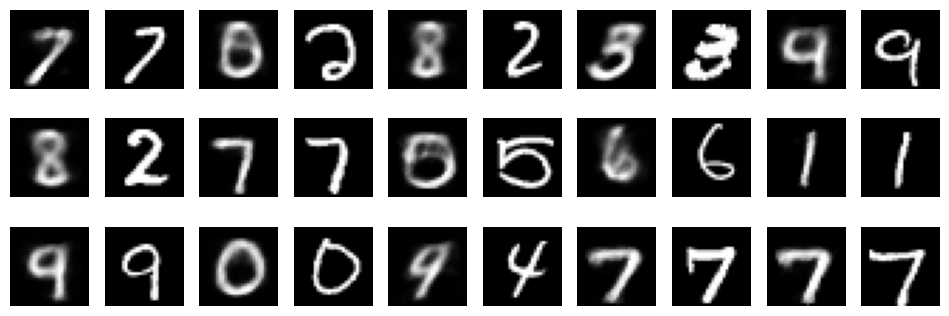

epoch [20/100], loss:0.1243


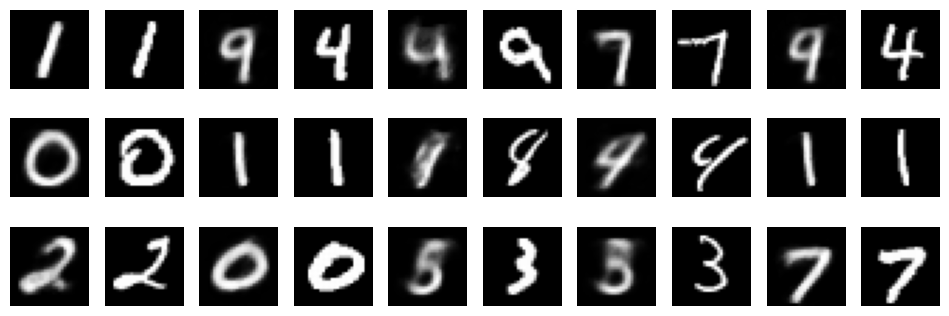

epoch [30/100], loss:0.1258


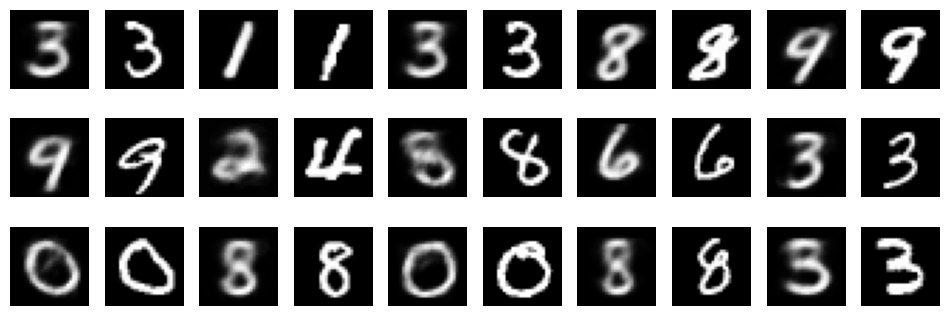

epoch [40/100], loss:0.1289


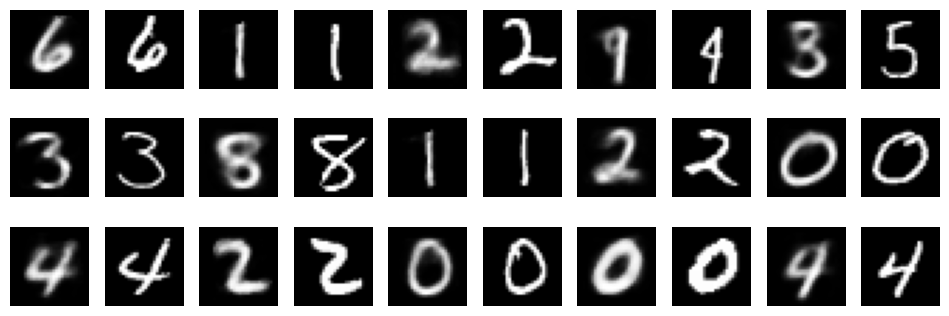

epoch [50/100], loss:0.1363


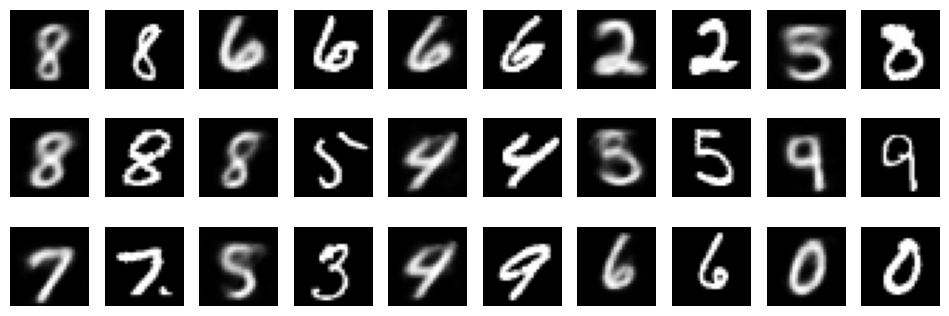

epoch [60/100], loss:0.1216


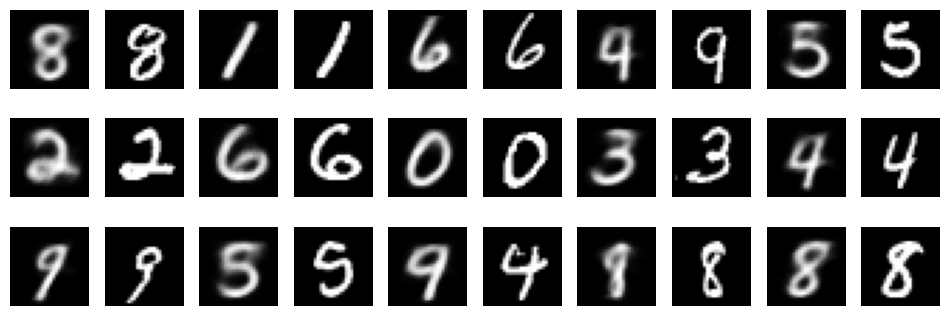

epoch [70/100], loss:0.1212


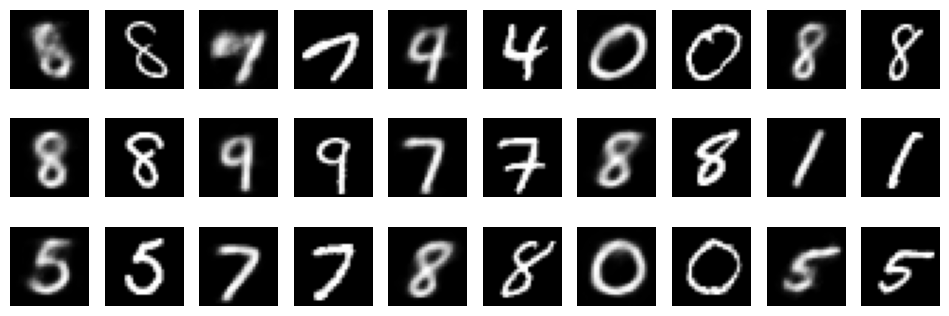

epoch [80/100], loss:0.1162


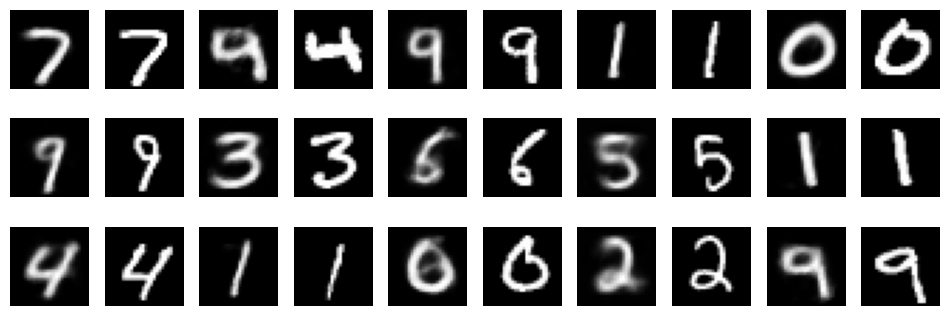

epoch [90/100], loss:0.1292


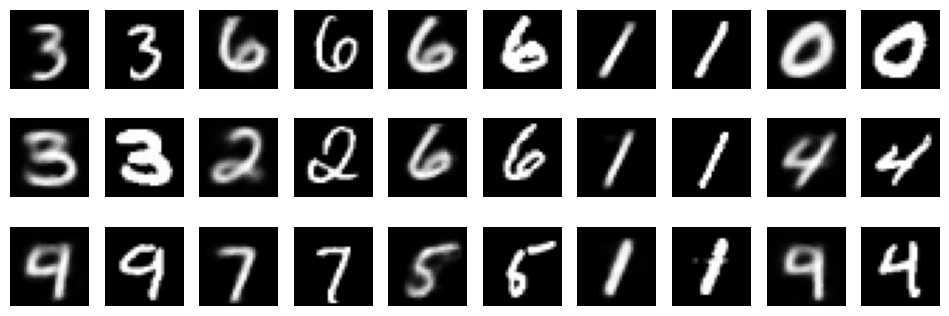

In [23]:
for epoch in range(num_epochs):
    for img, _ in dataLoader:
        img = img.view(-1, 28*28).to(device)
        # ===================forward=====================
        output = model(img)
        loss = loss_func(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    if epoch % 10 == 0:
        print(f'epoch [{epoch}/{num_epochs}], loss:{loss.item():.4f}')
        pic = to_img(output.detach().cpu())
        #save_image(pic, './mlp_img/image_{}.png'.format(epoch))

        pic1 = to_img(img.data.detach().cpu())
        #save_image(pic1, './mlp_img/Ori_image_{}.png'.format(epoch))
        showImagesToCompare(pic[:15], pic1[:15])

利用一下視覺化(Visualization)來觀察一下Embedding Feature和圖片的關係

In [24]:
axis_x = []
axis_y = []
answers = []
with torch.no_grad():
    for i, (data, target) in enumerate(dataLoader):
        inputs = data.view(-1, 28*28)
        answers += target.tolist()
        # Forward
        codes, outputs = model(inputs.to(device))
        codes = codes.detach().cpu()
        axis_x += codes[:, 0].tolist()
        axis_y += codes[:, 1].tolist()
answers = np.array(answers)
axis_x = np.array(axis_x)
axis_y = np.array(axis_y)
fig, ax = plt.subplots()
for i in range(len(answers)):
    ax.text(axis_x[i], axis_y[i], str(answers[i]), color=plt.cm.Set1(answers[i]))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

ValueError: too many values to unpack (expected 2)